# Headers (load libaries/packages/functions needed)

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%matplotlib inline
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *
#import plotly.express as px
import math
import scipy as sp
import scipy.io as sio
from scipy import stats
from scipy.constants import N_A
from scipy.optimize import curve_fit
import h5py
import numpy as np
import pandas as pd
import time
from IPython.display import Markdown, HTML, display
from pyitlib import discrete_random_variable as drv

pass

In [5]:
# Define some plotting styles that we will use.
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}

# 1 load files

Here we load the .mat files (provided by Tianyou) to python. We merge the datasets from the 2018/10/10 experiment and the 2018/12/01 experiment. We look at the samples collected at different times after triggering (1,2,3,5,7.5,10,20,30,60,120,180 min). For each cell, we extract the following data:

* Par spot number (estimation of MOI)
* cell length
* cI mRNA copy number
* cII mRNA copy number
* cro mRNA copy number

In [20]:
column_names = ['len','moi','ci','cro','cii','time']
df = pd.DataFrame(columns = column_names)

#####################
#filename1 = '20181010_infection_dataset_ty.mat'
filename2 = '20181201_infection_dataset_ty.mat'

time_after_triggering = [0.5,1,2,3,5,7.5,10,20,30,60,120,180]
column_id = [3,4,16,26,36]
for filename in [filename2]:
    mat_contents = sio.loadmat(filename)['enlistcell_total'];
    k = 0;
    for i in range(2,2+len(time_after_triggering)):
        tmp = mat_contents[0][i][:,column_id]
        tmp2=tmp[~np.isnan(tmp).any(axis=1)]
        tmp2=tmp2[tmp2[:,1]>0]
        df_tmp = pd.DataFrame(data=tmp2, 
                              index=[str(time_after_triggering[k])+'_'+str(i) for i in range(1,len(tmp2)+1)], 
                              columns=['len','moi','ci','cro','cii'])
        df_tmp['time']=np.full((len(tmp2),1),time_after_triggering[k])
        df = pd.concat([df,df_tmp])
        k = k+1;

df['len']=df['len']/(df['len'].median())
df['conc']= df['moi']/df['len']


In [21]:
df1 = df
df1['time'] = df['time']+2.5;

In [22]:
df4 = df1[df1['moi']<=4]
print(df4.groupby(['time','moi']).count())

           len   ci  cro  cii  conc
time  moi                          
3.0   1.0  267  267  267  267   267
      2.0  159  159  159  159   159
      3.0   50   50   50   50    50
      4.0   17   17   17   17    17
3.5   1.0   99   99   99   99    99
      2.0  109  109  109  109   109
      3.0   95   95   95   95    95
      4.0   43   43   43   43    43
4.5   1.0   93   93   93   93    93
      2.0   78   78   78   78    78
      3.0   42   42   42   42    42
      4.0   19   19   19   19    19
5.5   1.0   72   72   72   72    72
      2.0   66   66   66   66    66
      3.0   69   69   69   69    69
      4.0   41   41   41   41    41
7.5   1.0  194  194  194  194   194
      2.0  151  151  151  151   151
      3.0   89   89   89   89    89
      4.0   37   37   37   37    37
10.0  1.0  221  221  221  221   221
      2.0  195  195  195  195   195
      3.0  122  122  122  122   122
      4.0   55   55   55   55    55
12.5  1.0  123  123  123  123   123
      2.0  108  108  108  10

# 2 mRNA copy number at different MOI and different time points

## Zero-inflated negative binomial model

In [132]:
def negtive_binomial(k,r,p):
    return math.factorial(k+int(r)-1)/(math.factorial(k)*math.factorial(int(r)-1))*np.power(1-p,k)*np.power(p,r);
negtive_binomial = np.vectorize(negtive_binomial)


def zero_inflated_negtive_binomial(k,z,r,p):
    if k == 0:
        return z+(1-z)*negtive_binomial(0,r,p)
    else:
        return (1-z)*negtive_binomial(k,r,p)
zero_inflated_negtive_binomial = np.vectorize(zero_inflated_negtive_binomial)

## cI

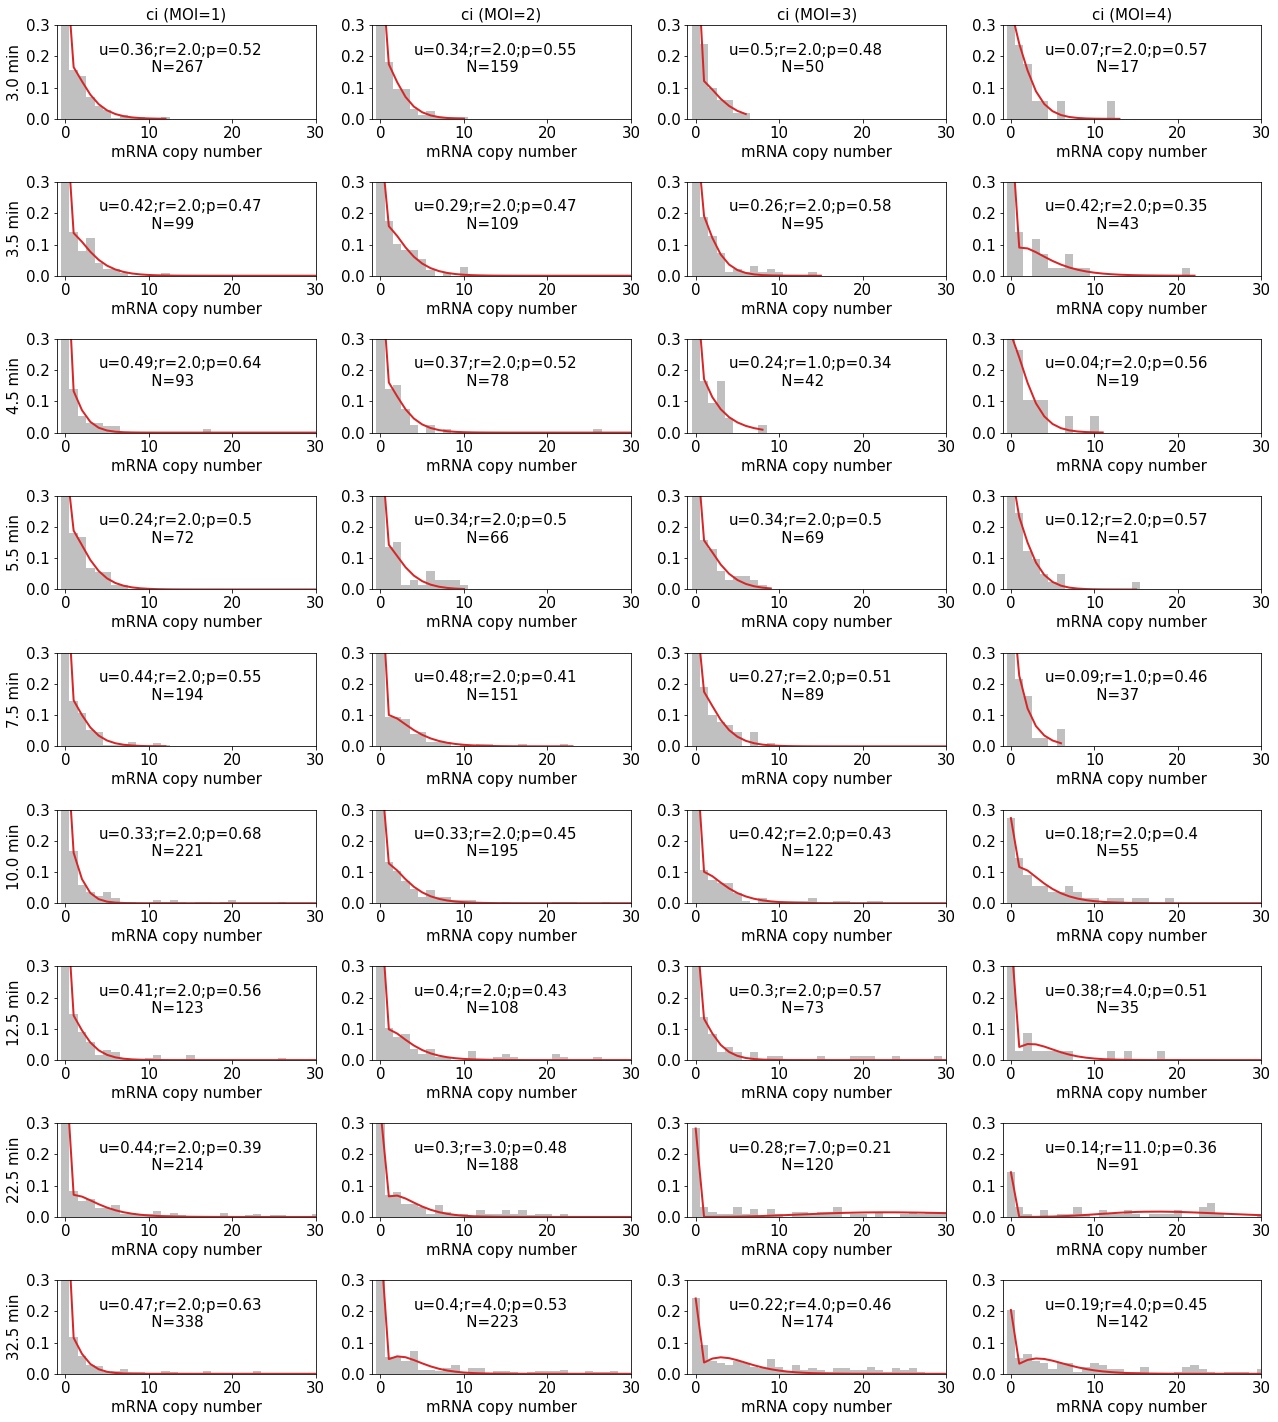

In [133]:
def plot_hist_zero_inflated_negtive_binomial(X):
    (bins,edges) = np.histogram(X,np.arange(-0.5*1,np.max(X)+1.5*1,1))
    centers = (edges[:-1]+edges[1:])/2
    xdata=centers;ydata=bins/(1.0*sum(bins))
    pdf = np.zeros((len(bins),2),dtype=float)
    pdf[:,0]=centers
    pdf[:,1] = bins.astype(double)/(np.sum(bins)*(centers[1]-centers[0]))
    
    x_ = np.mean(X[1:]); y_ = np.var(X[1:]);
    p_ini = 1-x_/y_;
    if (x_ > y_):
        p_ini = 0.1;
    r_ini = int(x_*(1-p_ini)/p_ini)+1;
    if (r_ini == 0):
        r_ini = 1;
    z_ini = pdf[0,1];
    p0_ini = [z_ini, r_ini, p_ini];
    popt, pcov = curve_fit(zero_inflated_negtive_binomial, xdata, ydata,bounds=((0,1,0),(1,np.inf,1)),p0=p0_ini,method='trf')
    
    return (pdf, popt)

barStyles={"width":1, "linewidth":0, "align":"center"}
matplotlib.rcParams.update({"figure.figsize": (18,20)})
k = 1;
times = np.array([0.5,1,2,3,5,7.5,10,20,30])+2.5; 

uninfected_ci = np.zeros((len(times),4)); 
burst_freq_ci = np.zeros((len(times),4)); 
burst_size_ci = np.zeros((len(times),4)); 

for j in range(0,len(times)):
    df2 = df1[df1['time']==times[j]];
    for i in [1,2,3,4]:
        x = df2[df2['moi']==i]['ci']
        (pdf, popt) = plot_hist_zero_inflated_negtive_binomial(x);
        
        uninfected_ci[j,i-1] = popt[0];
        burst_freq_ci[j,i-1] = popt[1];
        burst_size_ci[j,i-1] = (1-popt[2])/(1.0*popt[2]);
        
        subplot(len(times),4,k); k = k+1;
        bar(pdf[:,0],pdf[:,1], color='silver',label='raw', **barStyles)
        plot(pdf[:,0],zero_inflated_negtive_binomial(pdf[:,0],*popt),color='tab:red',label='ZINB', **plotStyles)
        xlabel('mRNA copy number');xlim(-1,30)
        unin_ = round(popt[0],2); r_ = round(int(popt[1])); p_ = round(popt[2],2)
        text(4,0.15,'u='+str(unin_)+';r='+str(r_)+';p='+str(p_)+'\n           N='+str(len(x)))
        if (i==1):
            ylabel(str(times[j])+' min')
        if (times[j]==3):
            title('ci'+' (MOI='+str(i)+')')
        ylim(0,0.3)
        
tight_layout()
plt.savefig('ci_all_moi_v2.pdf')

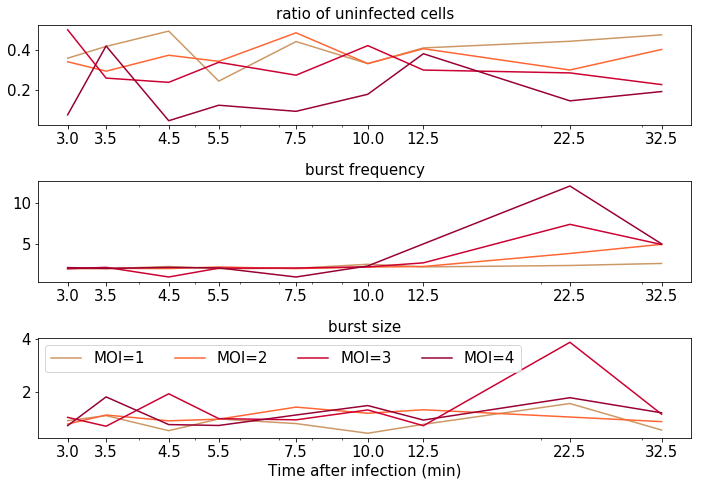

In [82]:
colors = ['#CC9966','#FF6633','#CC0033','#990033','#660033','#330033']

matplotlib.rcParams.update({"figure.figsize": (10,7)})
subplot(3,1,1)
title('ratio of uninfected cells')
for i in range(0,4):
    plot(times,uninfected_ci[:,i], color=colors[i])
xscale('log');xticks(times,[str(k) for k in times])
    
subplot(3,1,2)
title('burst frequency')
for i in range(0,4):
    plot(times,burst_freq_ci[:,i], color=colors[i])
xscale('log');xticks(times,[str(k) for k in times])

subplot(3,1,3)
title('burst size')
for i in range(0,4):
    plot(times,burst_size_ci[:,i], color=colors[i], label='MOI='+str(i+1))
xscale('log');xticks(times,[str(k) for k in times])
xlabel('Time after infection (min)');legend(loc='upper left', ncol=4)

tight_layout()

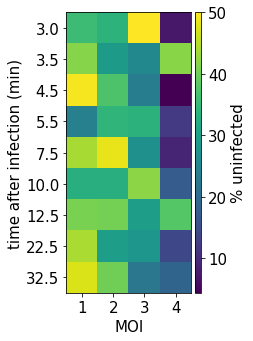

In [68]:
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *

#uninfected_ci is an array that stores the uninfected rate for each MOI at each time point,
#different columns correspond to different MOI, 
#different rows correspond to different time points. 

matplotlib.rcParams.update({"figure.figsize": (5,5)})
fig, ax = plt.subplots(1,1)
img = ax.imshow(uninfected_ci*100) 
x_label_list = ['1', '2', '3', '4']; 
y_label_list = ['3.0', '3.5', '4.5', '5.5','7.5','10.0','12.5','22.5','32.5']
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(x_label_list)
ax.set_yticks([0,1,2,3,4,5,6,7,8])
ax.set_yticklabels(y_label_list)
ax.set_xlabel('MOI')
ax.set_ylabel('time after infection (min)')
#adjust color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(img,cax=cax)
cbar.set_label('% uninfected', rotation=90)
tight_layout()


## Cro

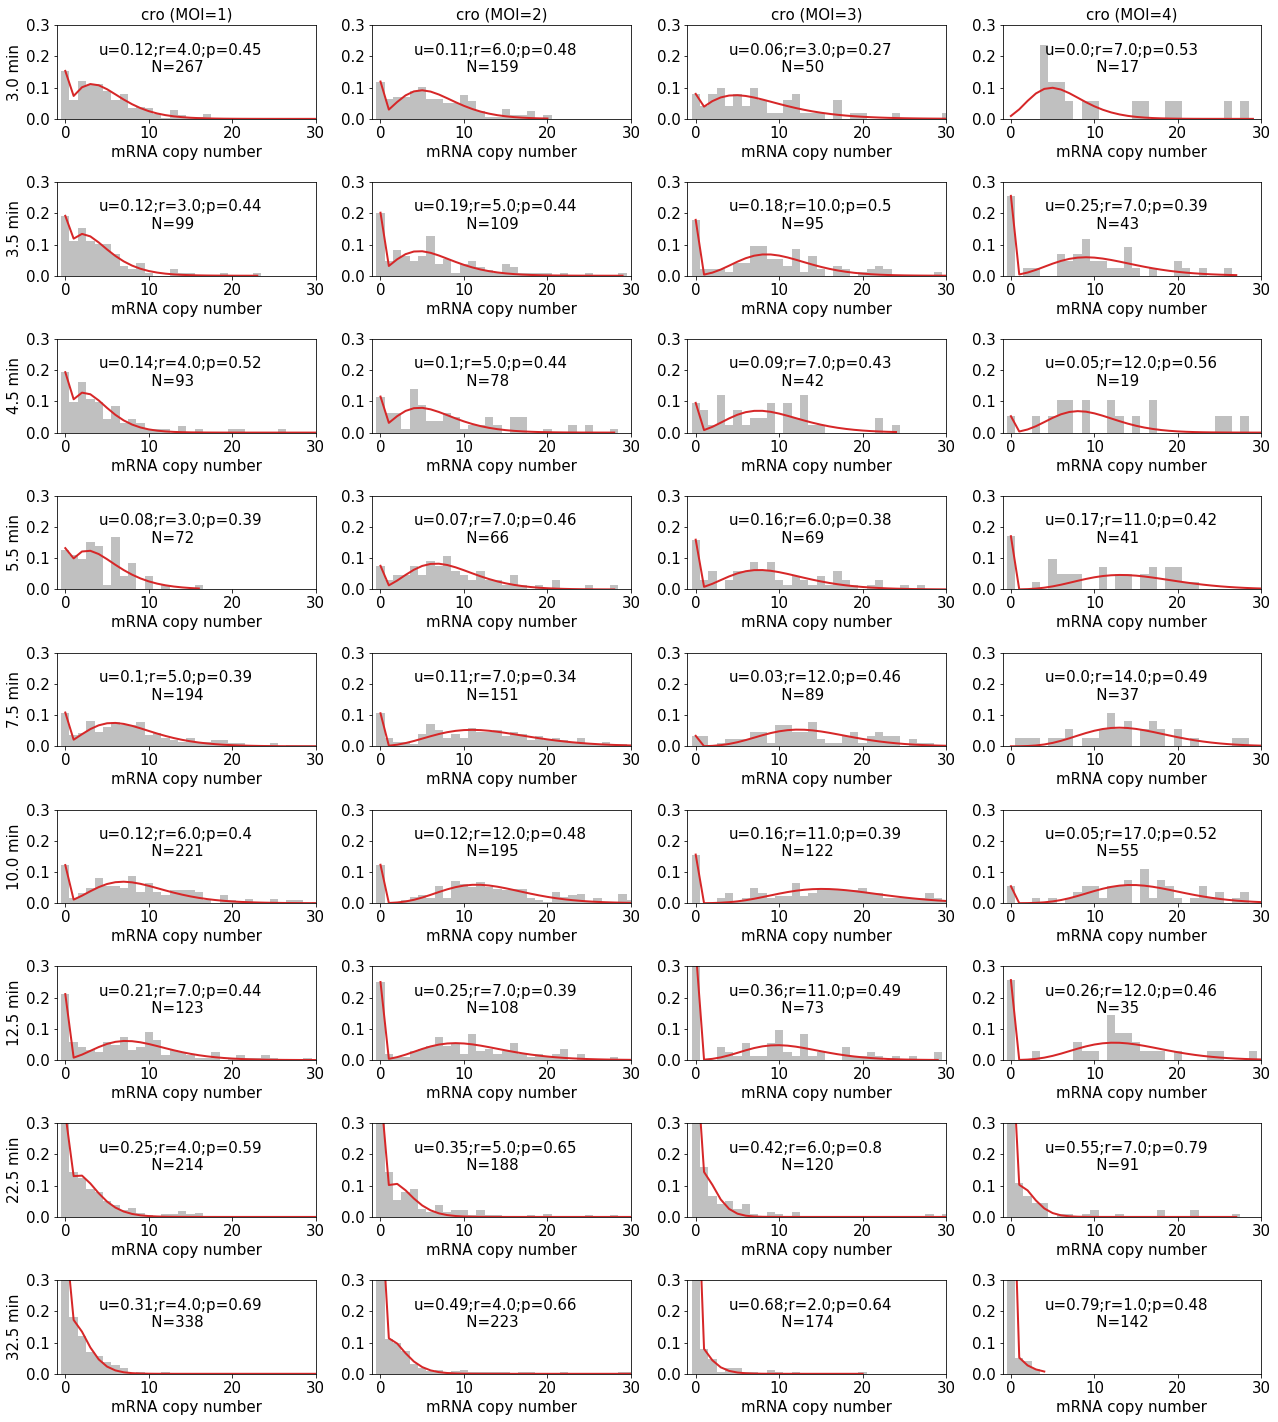

In [90]:
def plot_hist_zero_inflated_negtive_binomial2(X, uni_est):
    (bins,edges) = np.histogram(X,np.arange(-0.5*1,np.max(X)+1.5*1,1))
    centers = (edges[:-1]+edges[1:])/2
    xdata=centers;ydata=bins/(1.0*sum(bins))
    pdf = np.zeros((len(bins),2),dtype=float)
    pdf[:,0]=centers
    pdf[:,1] = bins.astype(double)/(np.sum(bins)*(centers[1]-centers[0]))
    
    x_ = np.mean(X[1:]); y_ = np.var(X[1:]);
    p_ini = 1-x_/y_;
    if (x_ > y_):
        p_ini = 0.2;
    r_ini = int(x_*(1-p_ini)/p_ini)+1;
    if (r_ini == 1):
        r_ini = 2;
    z_ini = uni_est; 
    p0_ini = [z_ini, r_ini, p_ini];
    popt, pcov = curve_fit(zero_inflated_negtive_binomial, xdata, ydata,bounds=((0,1,0),(1,np.inf,1)),p0=p0_ini,method='trf',maxfev=10000)
    
    return (pdf, popt)

barStyles={"width":1, "linewidth":0, "align":"center"}
matplotlib.rcParams.update({"figure.figsize": (18,20)})
k = 1;
times = np.array([0.5,1,2,3,5,7.5,10,20,30])+2.5; 

uninfected_cro = np.zeros((len(times),4)); 
burst_freq_cro = np.zeros((len(times),4)); 
burst_size_cro = np.zeros((len(times),4)); 

for j in range(0,len(times)):
    df2 = df1[df1['time']==times[j]];
    for i in [1,2,3,4]:
        x = df2[df2['moi']==i]['cro']
        (pdf, popt) = plot_hist_zero_inflated_negtive_binomial2(x, uninfected_ci[j,i-1]);
        
        uninfected_cro[j,i-1] = popt[0];
        burst_freq_cro[j,i-1] = popt[1];
        burst_size_cro[j,i-1] = (1-popt[2])/(1.0*popt[2]);
        
        subplot(len(times),4,k); k = k+1;
        bar(pdf[:,0],pdf[:,1], color='silver',label='raw', **barStyles)
        plot(pdf[:,0],zero_inflated_negtive_binomial(pdf[:,0],*popt),color='tab:red',label='ZINB', **plotStyles)
        xlabel('mRNA copy number');xlim(-1,30)
        unin_ = round(popt[0],2); r_ = round(int(popt[1])); p_ = round(popt[2],2)
        text(4,0.15,'u='+str(unin_)+';r='+str(r_)+';p='+str(p_)+'\n           N='+str(len(x)))
        if (i==1):
            ylabel(str(times[j])+' min')
        if (times[j]==3):
            title('cro'+' (MOI='+str(i)+')')
        ylim(0,0.3)

tight_layout()
plt.savefig('cro_all_moi_v2.pdf')

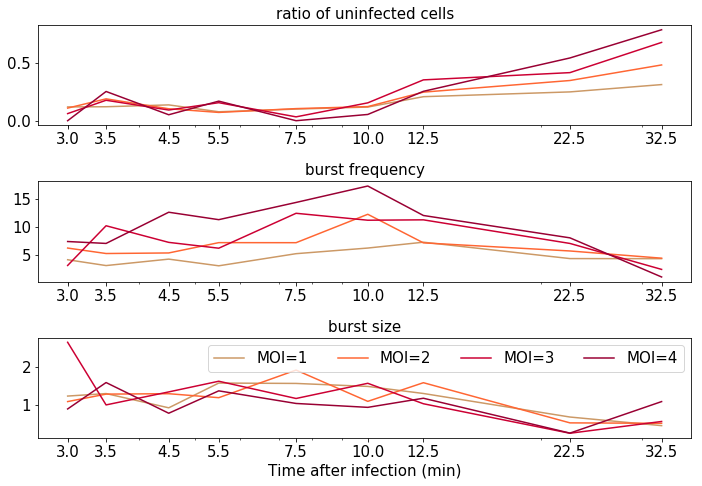

In [95]:
colors = ['#CC9966','#FF6633','#CC0033','#990033','#660033','#330033']

matplotlib.rcParams.update({"figure.figsize": (10,7)})
subplot(3,1,1)
title('ratio of uninfected cells')
for i in range(0,4):
    plot(times,uninfected_cro[:,i], color=colors[i])
xscale('log');xticks(times,[str(k) for k in times])
    
subplot(3,1,2)
title('burst frequency')
for i in range(0,4):
    plot(times,burst_freq_cro[:,i], color=colors[i])
xscale('log');xticks(times,[str(k) for k in times])

subplot(3,1,3)
title('burst size')
for i in range(0,4):
    plot(times,burst_size_cro[:,i], color=colors[i], label='MOI='+str(i+1))
xscale('log');xticks(times,[str(k) for k in times])
xlabel('Time after infection (min)');legend(loc='upper right', ncol=4)

tight_layout()

## cII

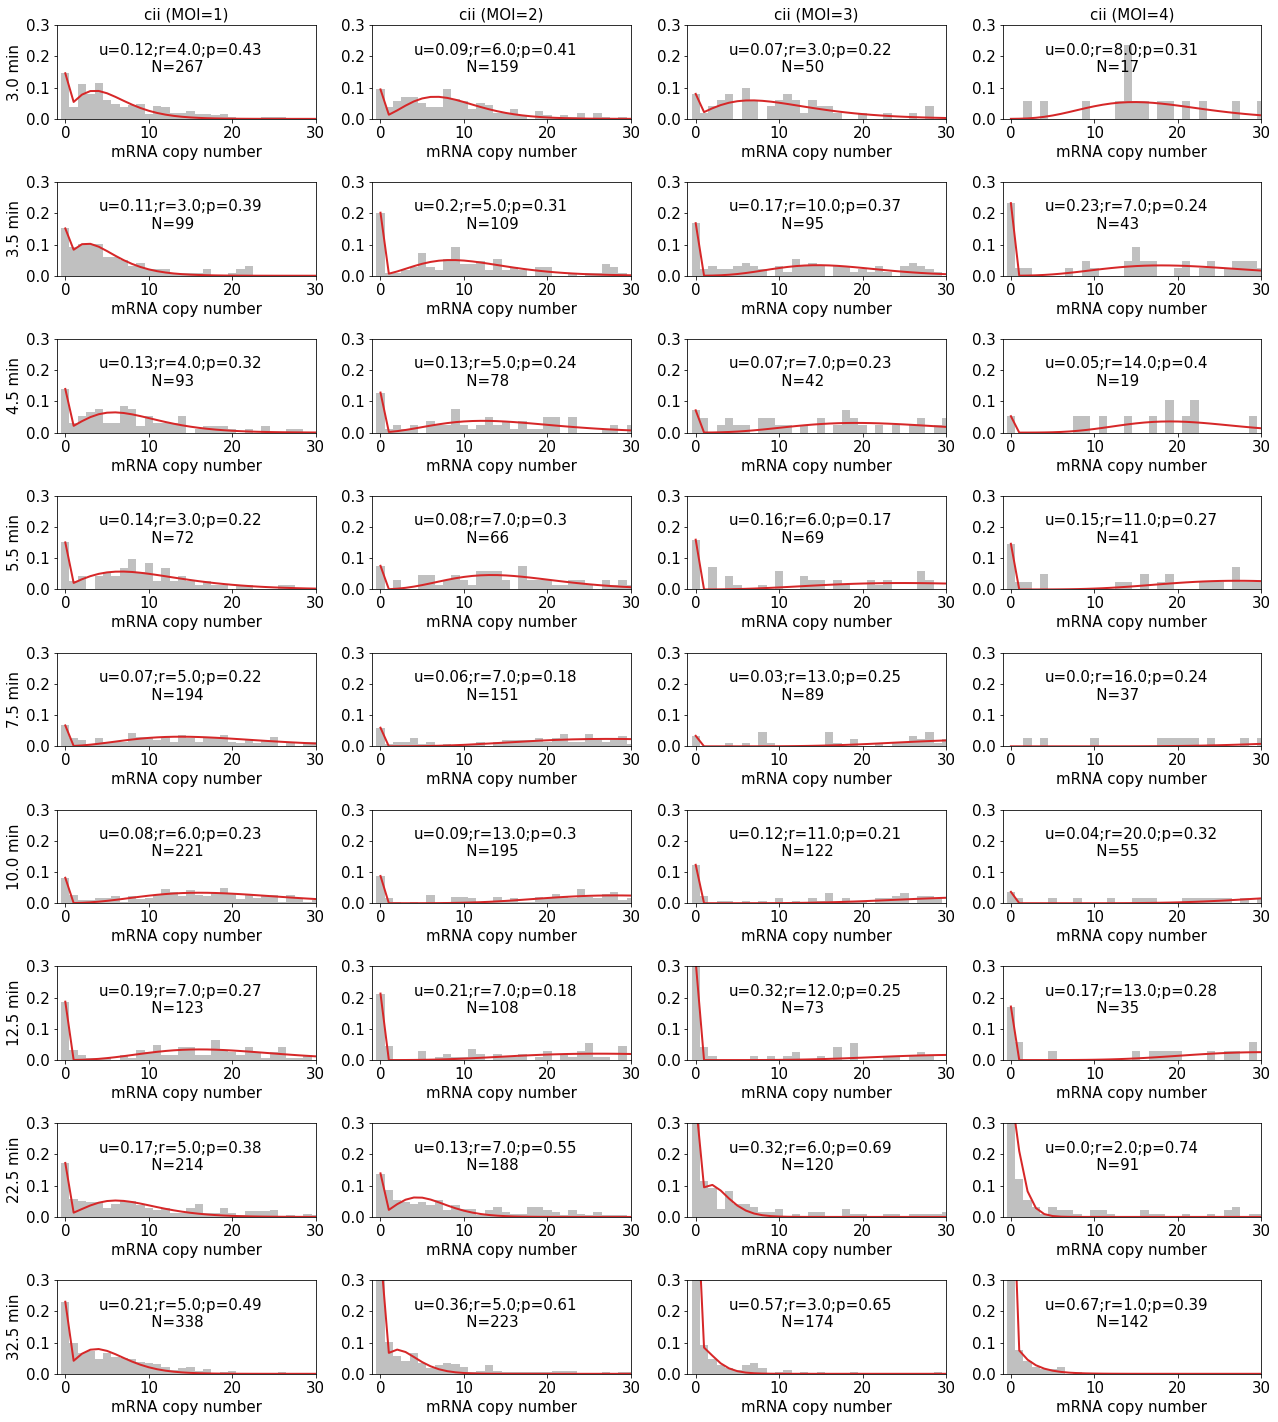

In [121]:
def plot_hist_negtive_binomial(X):
    (bins,edges) = np.histogram(X,np.arange(-0.5*1,np.max(X)+1.5*1,1))
    centers = (edges[:-1]+edges[1:])/2
    xdata=centers;ydata=bins/(1.0*sum(bins))
    pdf = np.zeros((len(bins),2),dtype=float)
    pdf[:,0]=centers
    pdf[:,1] = bins.astype(double)/(np.sum(bins)*(centers[1]-centers[0]))
    
    x_ = np.mean(X); y_ = np.var(X);
    p_ini = 1-x_/y_;
    if (p_ini < 0.8):
        p_ini = p_ini + 0.2;
    r_ini = int(x_*(1-p_ini)/p_ini);
    if (r_ini == 0):
        r_ini = 1;
    p0_ini = [r_ini, p_ini];
    popt, pcov = curve_fit(negtive_binomial, xdata, ydata,bounds=((1,0),(np.inf,1)),p0=p0_ini)
    
    return (pdf, popt)

def plot_hist_zero_inflated_negtive_binomial3(X, z_est, r_est, p_est):
    (bins,edges) = np.histogram(X,np.arange(-0.5*1,np.max(X)+1.5*1,1))
    centers = (edges[:-1]+edges[1:])/2
    xdata=centers;ydata=bins/(1.0*sum(bins))
    pdf = np.zeros((len(bins),2),dtype=float)
    pdf[:,0]=centers
    pdf[:,1] = bins.astype(double)/(np.sum(bins)*(centers[1]-centers[0]))
    
    z_ini = z_est; 
    r_ini = r_est;
    p_ini = 1.0/(1.0+p_est);
    p0_ini = [z_ini, r_ini, p_ini];
    popt, pcov = curve_fit(zero_inflated_negtive_binomial, xdata, ydata,bounds=((0,1,0),(1,np.inf,1)),p0=p0_ini,method='trf',maxfev=1000)
    
    return (pdf, popt)

barStyles={"width":1, "linewidth":0, "align":"center"}
matplotlib.rcParams.update({"figure.figsize": (18,20)})
k = 1;
times = np.array([0.5,1,2,3,5,7.5,10,20,30])+2.5; 

uninfected_cii = np.zeros((len(times),4)); 
burst_freq_cii = np.zeros((len(times),4)); 
burst_size_cii = np.zeros((len(times),4)); 

for j in range(0,len(times)):
    df2 = df1[df1['time']==times[j]];
    for i in [1,2,3,4]:
        x = df2[df2['moi']==i]['cii']
        
        subplot(len(times),4,k); k = k+1;
        if (j==7 and i==4):
            (pdf, popt) = plot_hist_negtive_binomial(x)
            
            uninfected_cii[j,i-1] = 0;
            burst_freq_cii[j,i-1] = popt[0];
            burst_size_cii[j,i-1] = (1-popt[1])/(1.0*popt[1]);

            bar(pdf[:,0],pdf[:,1], color='silver',label='raw', **barStyles)
            plot(pdf[:,0],negtive_binomial(pdf[:,0],*popt),color='tab:red',label='ZINB', **plotStyles)
            unin_ = round(0,2); r_ = round(int(popt[0])); p_ = round(popt[1],2)
            
        else:
            (pdf, popt) = plot_hist_zero_inflated_negtive_binomial3(x, uninfected_cro[j,i-1],burst_freq_cro[j,i-1],burst_size_cro[j,i-1]);
            
            uninfected_cii[j,i-1] = popt[0];
            burst_freq_cii[j,i-1] = popt[1];
            burst_size_cii[j,i-1] = (1-popt[2])/(1.0*popt[2]);
            
            bar(pdf[:,0],pdf[:,1], color='silver',label='raw', **barStyles)
            plot(pdf[:,0],zero_inflated_negtive_binomial(pdf[:,0],*popt),color='tab:red',label='ZINB', **plotStyles)
            unin_ = round(popt[0],2); r_ = round(int(popt[1])); p_ = round(popt[2],2)
        xlabel('mRNA copy number');xlim(-1,30)
        text(4,0.15,'u='+str(unin_)+';r='+str(r_)+';p='+str(p_)+'\n           N='+str(len(x)))
        if (i==1):
            ylabel(str(times[j])+' min')
        if (times[j]==3):
            title('cii'+' (MOI='+str(i)+')')
        ylim(0,0.3)

tight_layout()
plt.savefig('cii_all_moi_v2.pdf')

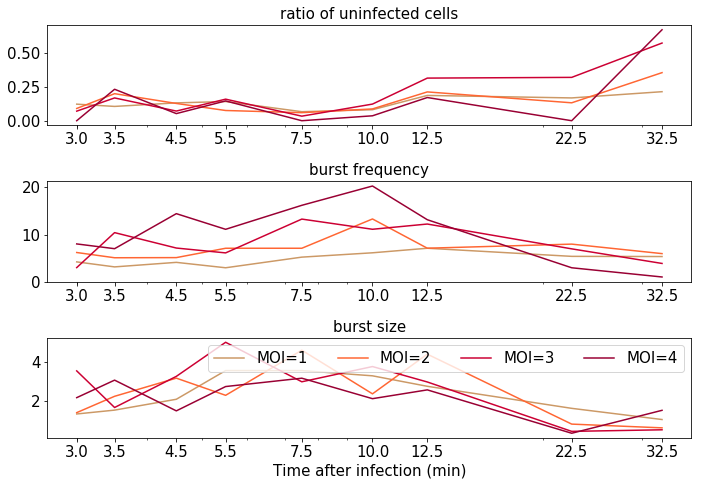

In [122]:
colors = ['#CC9966','#FF6633','#CC0033','#990033','#660033','#330033']

matplotlib.rcParams.update({"figure.figsize": (10,7)})
subplot(3,1,1)
title('ratio of uninfected cells')
for i in range(0,4):
    plot(times,uninfected_cii[:,i], color=colors[i])
xscale('log');xticks(times,[str(k) for k in times])
    
subplot(3,1,2)
title('burst frequency')
for i in range(0,4):
    plot(times,burst_freq_cii[:,i], color=colors[i])
xscale('log');xticks(times,[str(k) for k in times])

subplot(3,1,3)
title('burst size')
for i in range(0,4):
    plot(times,burst_size_cii[:,i], color=colors[i], label='MOI='+str(i+1))
xscale('log');xticks(times,[str(k) for k in times])
xlabel('Time after infection (min)');legend(loc='upper right', ncol=4)

tight_layout()

/miniconda3/lib/python2.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


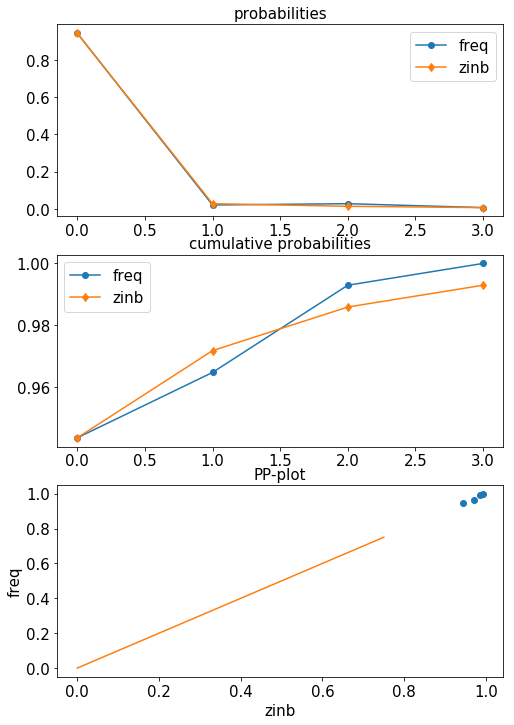

In [123]:
import statsmodels.distributions.discrete as distr
from statsmodels.discrete.discrete_model import NegativeBinomialP, Poisson, GeneralizedPoisson
from statsmodels.discrete.count_model import (ZeroInflatedNegativeBinomialP, ZeroInflatedPoisson,
                                              ZeroInflatedGeneralizedPoisson)
import statsmodels.discrete._diagnostics_count as dia

df2 = df1[df1['time']==times[8]];
endog = np.array(df2[df2['moi']==4]['cro'].to_numpy())
endog = endog.astype(int)
nobs = len(endog)
exog = np.ones((nobs, 2))
exog[:nobs//2, 1] = 0

model_zinb = ZeroInflatedNegativeBinomialP(endog, exog, p=2)
res_zinb = model_zinb.fit(method='lbfgs', bounds = ((None, None),(0,1),(0,1),(1,None)), maxiter=50000, maxfun=50000)

probs_zinb = res_zinb.predict(which='prob')
probsm_zinb = probs_zinb.mean(0)
freq = np.bincount(endog)/(1.0*nobs)
_= dia.plot_probs(freq, probsm_zinb, label='zinb')


[2.06365333 0.         0.         1.        ]


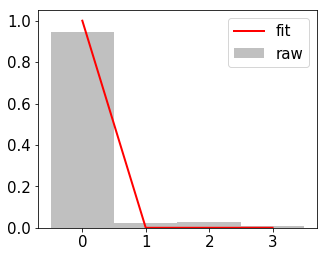

In [125]:
z=res_zinb.params[1]
p=res_zinb.params[2]
r=int(res_zinb.params[3])

print(res_zinb.params)
#zero_inflated_negtive_binomial(k,z,r,p)

X = endog
(bins,edges) = np.histogram(X,np.arange(-0.5*1,np.max(X)+1.5*1,1))
centers = (edges[:-1]+edges[1:])/2
xdata=centers;ydata=bins/(1.0*sum(bins))
pdf = np.zeros((len(bins),2),dtype=float)
pdf[:,0]=centers
pdf[:,1] = bins.astype(double)/(np.sum(bins)*(centers[1]-centers[0]))

matplotlib.rcParams.update({"figure.figsize": (5,4)})
bar(pdf[:,0],pdf[:,1], color='silver',label='raw', **barStyles)
plot(xdata,zero_inflated_negtive_binomial(xdata,1-z,r,p),label='fit',color='red',**plotStyles)
legend()

Optimization terminated successfully.
         Current function value: 0.288687
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
[-2.31676973e+00  6.64583481e-14  1.64494911e+01]


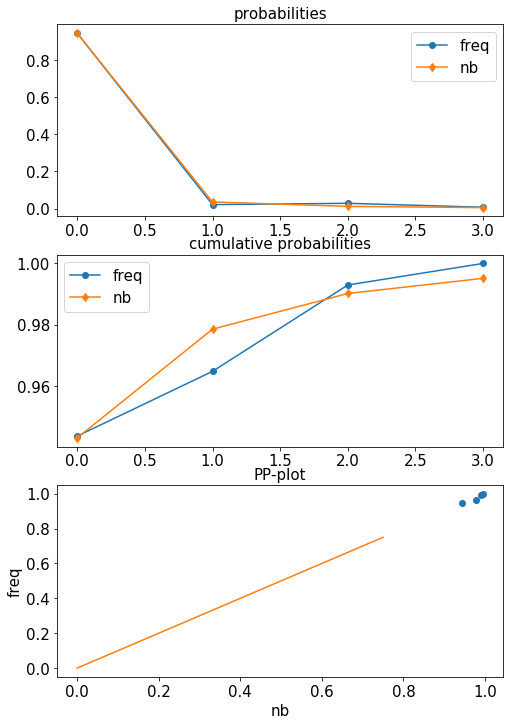

In [126]:
model_nb = NegativeBinomialP(endog, exog, p=2)
res_nb = model_nb.fit(method='bfgs', maxiter=5000, maxfun=5000)
probs_nb = res_nb.predict(which='prob')
probsm_nb = probs_nb.mean(0)

_= dia.plot_probs(freq, probsm_nb, label='nb')
print(res_nb.params)

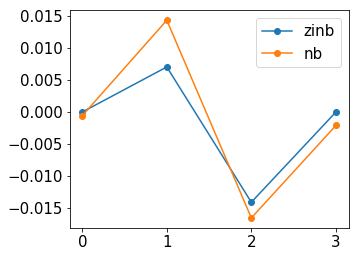

In [128]:
matplotlib.rcParams.update({"figure.figsize": (5,4)})
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(probsm_zinb - freq, '-o', label='zinb')
ax.plot(probsm_nb - freq, '-o', label='nb')
ax.legend()

In [129]:
dia.test_chisquare_prob(res_zinb, probs_zinb[:, :5])[:-1]

/miniconda3/lib/python2.7/site-packages/statsmodels/discrete/_diagnostics_count.py:201: UserWarning: auxiliary model is rank deficient
  warnings.warn('auxiliary model is rank deficient')


(142.0, 9.724814489694086e-33, 1)

In [130]:
dia.test_chisquare_prob(res_nb, probs_nb[:, :5])[:-1]

(142.0, 1.4624862272512401e-31, 2)